In [13]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan

In [14]:
class Profile():
    def __init__(self, filename):
        self._metadata = {}
        self._projects = {}
        self._votes = {}
        with open(filename, "r", encoding="utf8") as self.file:
            self.__read_lines()

        self.__convert_projects()
        self.__convert_votes()
        
    @property
    def ballots(self):
        return self._ballots
        
    def __convert_projects(self):
        self._projectid_to_index = {}
        tmp = {}
        for i, (proj_id, budget) in enumerate(self._projects.items()):
            self._projectid_to_index[proj_id] = i
            tmp[i] = budget
        self._projects = tmp
        
    def __convert_votes(self):
        self._votes = [np.array([self._projectid_to_index[x]]) if isinstance(x, int) else np.array([self._projectid_to_index[int(y)] for y in x.split(",")]) for x in self._votes.values()]
        self._ballots = np.zeros((self._metadata["num_votes"], self._metadata["num_projects"]))
        for i, vote in enumerate(self._votes):
            self._ballots[i,vote] = 1
       
    def __read_lines(self):
        _sections = {"META":self._metadata, 
                     "PROJECTS":self._projects, 
                     "VOTES":self._votes}
        _slices = {"key":"value",
                   "project_id":"cost",
                   "voter_id":"vote"}
        
        for line in self.file:
            line = line.strip()

            items = line.split(";")
            # find the right index for one of the properties (value, cost, vote)
            try:
                index = items.index(_slices[items[0]])
            except KeyError:
                pass
            else:
                continue 
            
            # switch to a new dict when a new section is found
            try: 
                _current = _sections[line]
            except KeyError:
                pass
            else:
                continue
            
            # read data
            try:
                try:
                    key = int(items[0])
                except ValueError:
                    key = items[0]
                _current[key] = int(items[index])
            except IndexError:
                pass
            except ValueError:
                _current[key] = items[index]

In [15]:
with open("data//sorted_files.pkl", 'rb') as f:
    file_division = pickle.load(f)

In [16]:
approval_profile_files = sorted(file_division['approval'], key=lambda x: x[2], reverse=True)

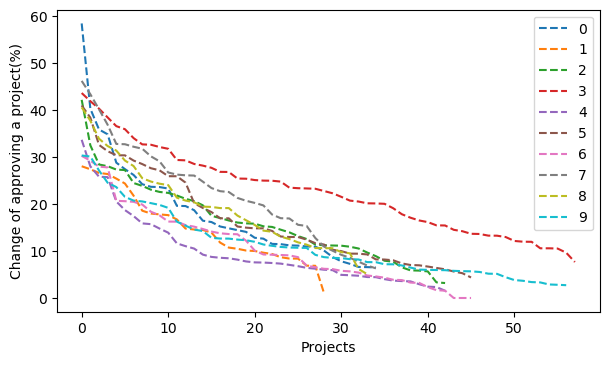

In [17]:
rcParams['figure.figsize'] = 7, 4
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 10})
for i in range(10):
    x = Profile(approval_profile_files[i][0])
    plt.plot(x.ballots.mean(0)*100,'--',label=i)
plt.legend()
plt.xlabel("Projects")
plt.ylabel("Change of approving a project(%)")
plt.show()

In [18]:
i = 0
old_data = Profile(approval_profile_files[i][0]).ballots

# data = [x/sum(x) if sum(x) else x for x in old_data]
data = old_data

In [19]:
reducer = umap.UMAP(n_components=2, n_neighbors=50, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(8700, 2)

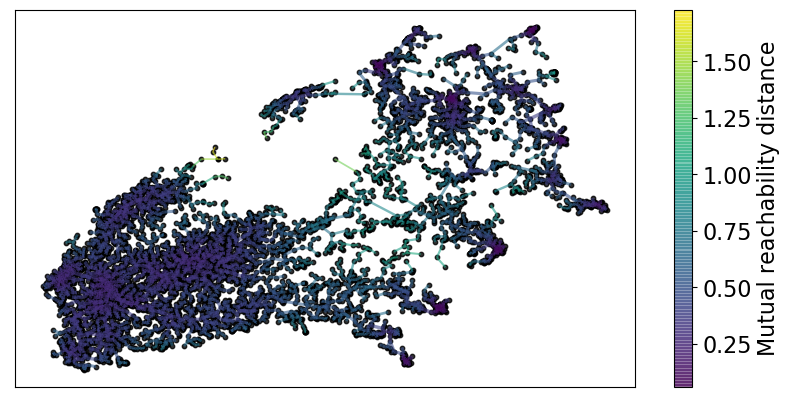

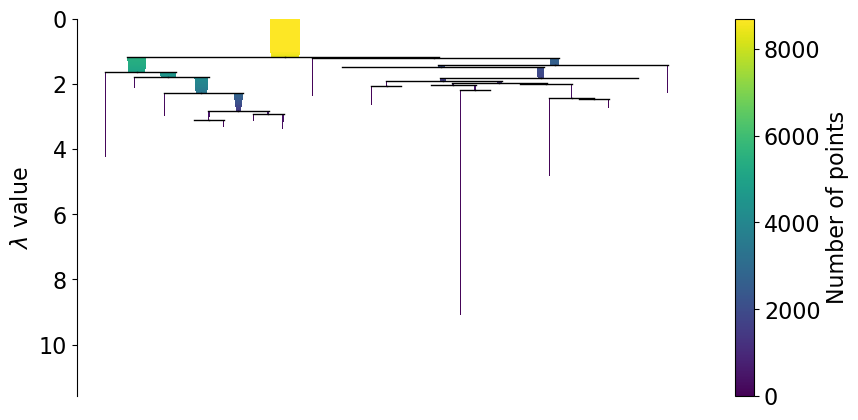

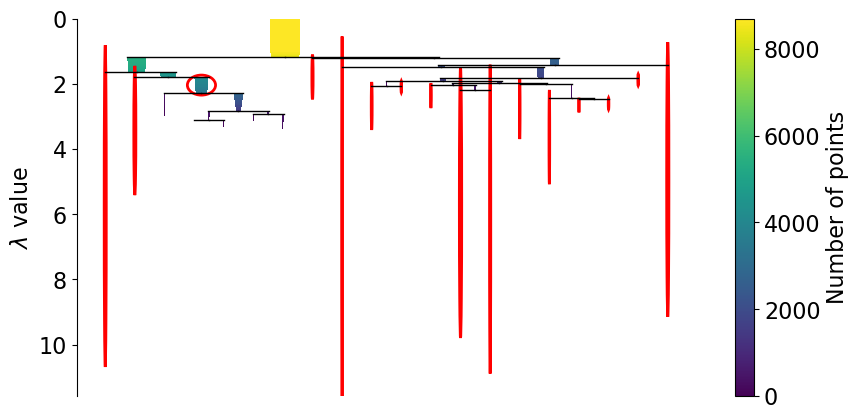

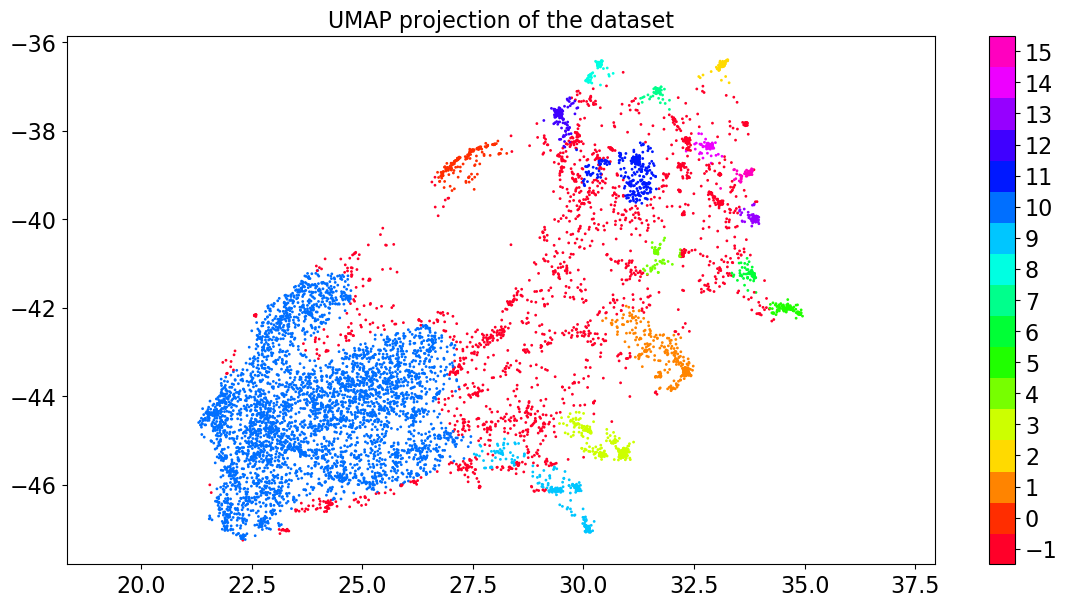

In [32]:
# n_clusters = 10
# k = KMeans(n_clusters).fit(embedding)

# n_clusters = 10
# k = GaussianMixture(n_clusters).fit(embedding)
# k.labels_ = k.predict(embedding)

# k = DBSCAN(0.45, len(data)//250).fit(embedding)
# n_clusters = max(k.labels_) + 1

k = hdbscan.HDBSCAN(min_cluster_size=len(data)//100, gen_min_span_tree=True).fit(embedding)
n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset', fontsize=16)

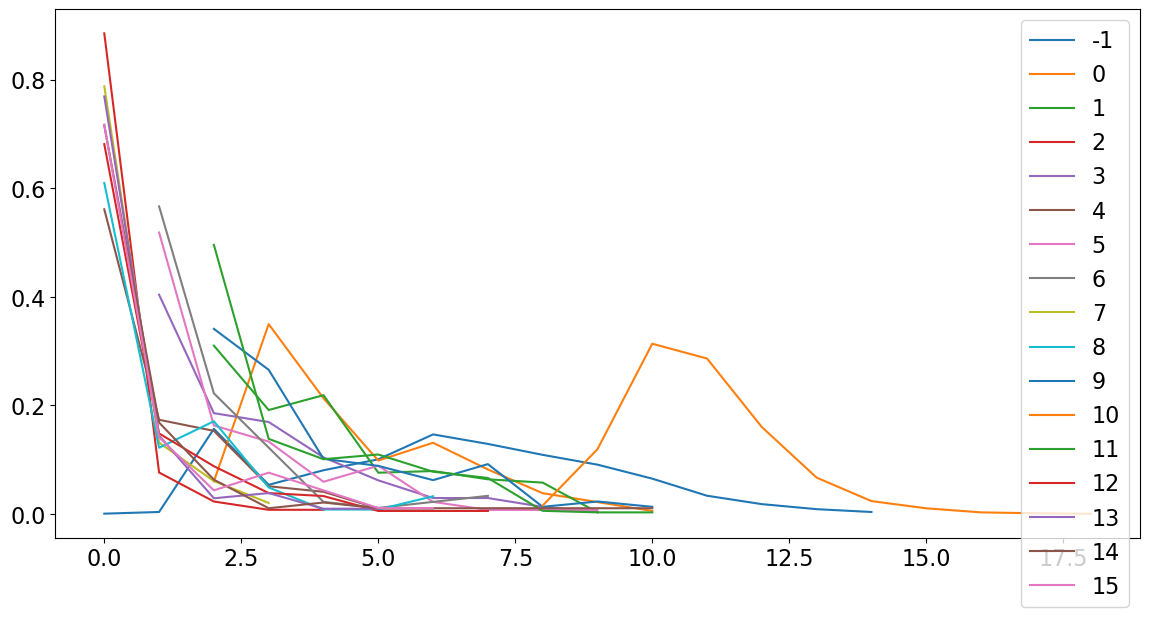

In [33]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
n_clusters = max(k.labels_) + 1

cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(old_data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, old_data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

0
{0: 0.08196721311475409, 1: 0.09836065573770492, 2: 0.07103825136612021, 3: 0.07650273224043716, 4: 0.09836065573770492, 5: 0.03278688524590164, 6: 0.18579234972677597, 7: 0.17486338797814208, 8: 0.01092896174863388, 9: 0.0546448087431694, 10: 0.0273224043715847, 11: 0.03825136612021858, 12: 0.04918032786885246, 13: 0.03278688524590164, 14: 0.0273224043715847, 15: 0.04918032786885246, 16: 0.07103825136612021, 17: 0.06557377049180328, 18: 0.825136612021858, 19: 0.366120218579235, 20: 0.03825136612021858, 21: 0.060109289617486336, 22: 0.08196721311475409, 23: 0.6338797814207651, 24: 0.02185792349726776, 25: 0.04371584699453552, 26: 0.03278688524590164, 27: 0.09289617486338798, 28: 0.04918032786885246, 29: 0.04371584699453552, 30: 0.02185792349726776, 31: 0.18579234972677597, 32: 0.04371584699453552, 33: 0.02185792349726776, 34: 0.0546448087431694}
183


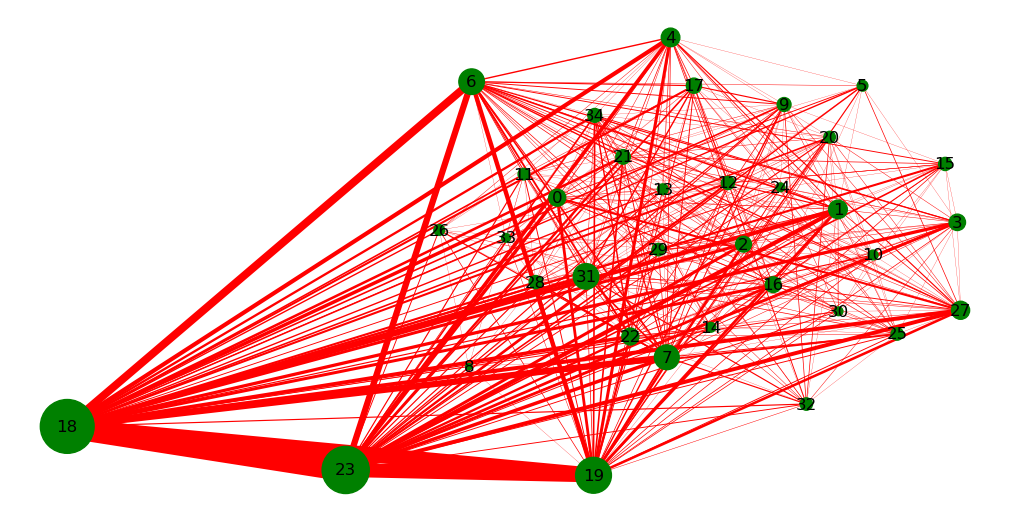

1
{0: 0.11246200607902736, 1: 0.182370820668693, 2: 0.057750759878419454, 3: 0.06382978723404255, 4: 0.1762917933130699, 5: 0.10638297872340426, 6: 0.0790273556231003, 7: 0.03951367781155015, 8: 0.0364741641337386, 9: 0.993920972644377, 10: 0.07598784194528875, 11: 0.0547112462006079, 12: 0.19148936170212766, 13: 0.0729483282674772, 14: 0.030395136778115502, 15: 0.0972644376899696, 16: 0.10030395136778116, 17: 0.0243161094224924, 18: 0.030395136778115502, 19: 0.03951367781155015, 20: 0.0486322188449848, 21: 0.0243161094224924, 22: 0.1337386018237082, 23: 0.015197568389057751, 24: 0.0486322188449848, 25: 0.07598784194528875, 26: 0.06990881458966565, 27: 0.06990881458966565, 28: 0.04559270516717325, 29: 0.0425531914893617, 30: 0.06990881458966565, 31: 0.0364741641337386, 32: 0.0182370820668693, 33: 0.0243161094224924, 34: 0.06382978723404255}
329


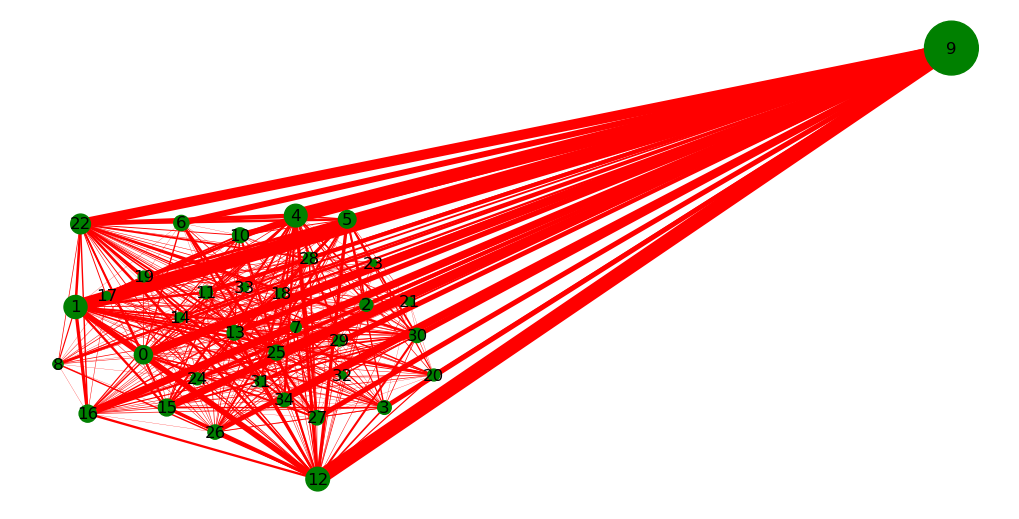

2
{0: 0.0, 1: 0.0, 2: 0.022900763358778626, 3: 0.030534351145038167, 4: 0.0, 5: 0.0, 6: 0.007633587786259542, 7: 0.0, 8: 0.0, 9: 0.007633587786259542, 10: 0.015267175572519083, 11: 0.007633587786259542, 12: 0.0, 13: 0.007633587786259542, 14: 0.015267175572519083, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.015267175572519083, 21: 0.015267175572519083, 22: 0.0, 23: 0.007633587786259542, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.007633587786259542, 28: 0.007633587786259542, 29: 0.0, 30: 0.007633587786259542, 31: 0.0, 32: 0.0, 33: 0.0, 34: 1.0}
131


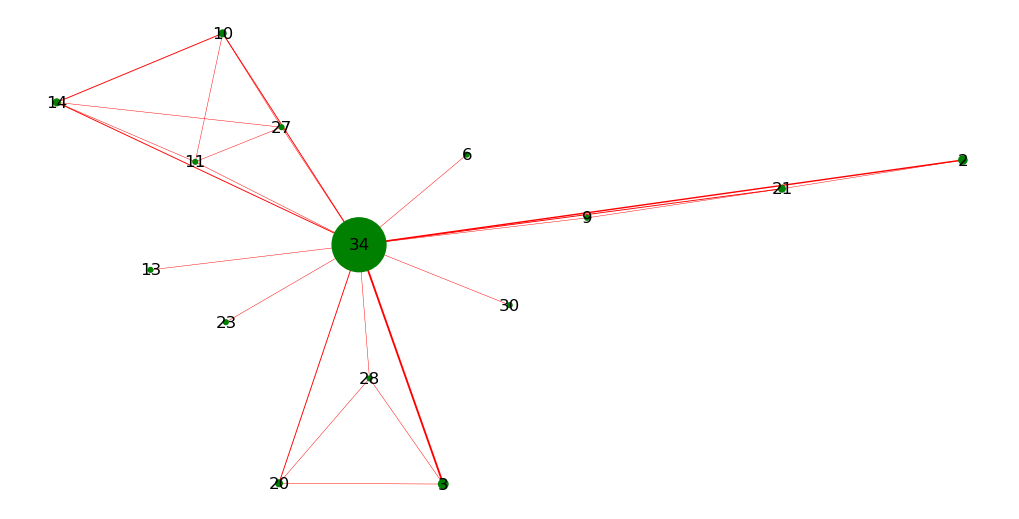

3
{0: 0.993485342019544, 1: 0.250814332247557, 2: 0.0, 3: 0.18566775244299674, 4: 0.0749185667752443, 5: 0.019543973941368076, 6: 0.009771986970684038, 7: 0.07166123778501629, 8: 0.04234527687296417, 9: 0.04560260586319218, 10: 0.05211726384364821, 11: 0.05211726384364821, 12: 0.03908794788273615, 13: 0.03908794788273615, 14: 0.03257328990228013, 15: 0.048859934853420196, 16: 0.035830618892508145, 17: 0.04560260586319218, 18: 0.02280130293159609, 19: 0.06840390879478828, 20: 0.006514657980456026, 21: 0.035830618892508145, 22: 0.04560260586319218, 23: 0.013029315960912053, 24: 0.029315960912052116, 25: 0.019543973941368076, 26: 0.035830618892508145, 27: 0.029315960912052116, 28: 0.08143322475570032, 29: 0.07166123778501629, 30: 0.016286644951140065, 31: 0.026058631921824105, 32: 0.013029315960912053, 33: 0.026058631921824105, 34: 0.09120521172638436}
307


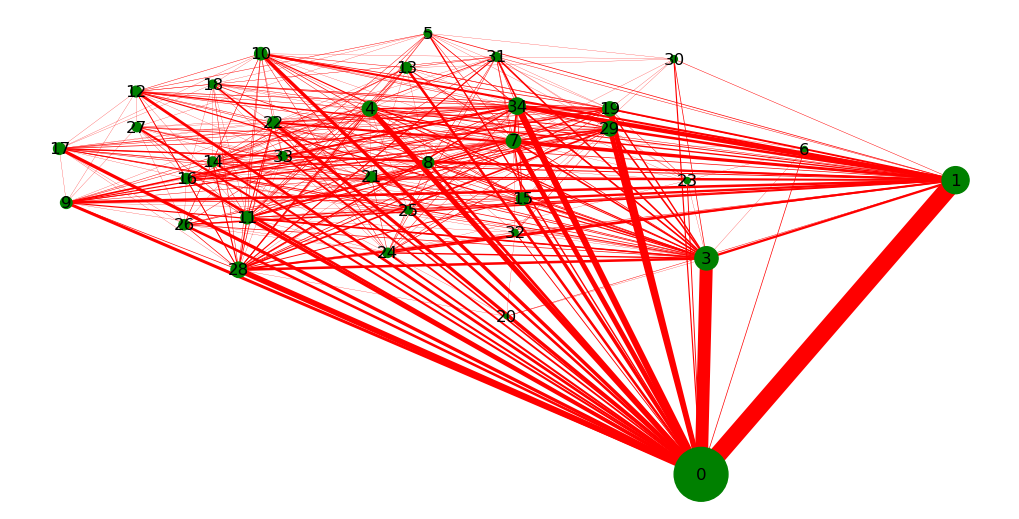

4
{0: 0.0, 1: 0.04081632653061224, 2: 0.0, 3: 0.061224489795918366, 4: 0.01020408163265306, 5: 0.030612244897959183, 6: 0.0, 7: 0.04081632653061224, 8: 0.030612244897959183, 9: 0.0, 10: 0.0, 11: 0.05102040816326531, 12: 0.29591836734693877, 13: 0.0, 14: 0.030612244897959183, 15: 0.9285714285714286, 16: 0.02040816326530612, 17: 0.01020408163265306, 18: 0.01020408163265306, 19: 0.01020408163265306, 20: 0.01020408163265306, 21: 0.0, 22: 0.04081632653061224, 23: 0.0, 24: 0.02040816326530612, 25: 0.0, 26: 0.04081632653061224, 27: 0.04081632653061224, 28: 0.02040816326530612, 29: 0.01020408163265306, 30: 0.0, 31: 0.0, 32: 0.030612244897959183, 33: 0.0, 34: 0.0}
98


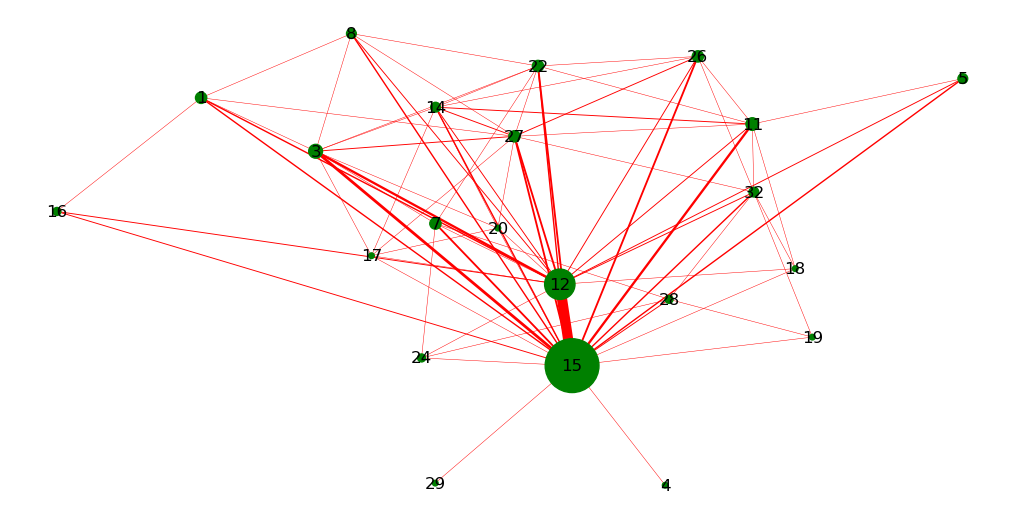

5
{0: 0.0962962962962963, 1: 0.05925925925925926, 2: 0.08888888888888889, 3: 0.05925925925925926, 4: 0.08148148148148149, 5: 0.6148148148148148, 6: 0.05925925925925926, 7: 0.022222222222222223, 8: 1.0, 9: 0.07407407407407407, 10: 0.037037037037037035, 11: 0.022222222222222223, 12: 0.014814814814814815, 13: 0.022222222222222223, 14: 0.022222222222222223, 15: 0.037037037037037035, 16: 0.07407407407407407, 17: 0.007407407407407408, 18: 0.007407407407407408, 19: 0.02962962962962963, 20: 0.014814814814814815, 21: 0.007407407407407408, 22: 0.02962962962962963, 23: 0.007407407407407408, 24: 0.037037037037037035, 25: 0.037037037037037035, 26: 0.022222222222222223, 27: 0.02962962962962963, 28: 0.02962962962962963, 29: 0.037037037037037035, 30: 0.022222222222222223, 31: 0.02962962962962963, 32: 0.007407407407407408, 33: 0.022222222222222223, 34: 0.02962962962962963}
135


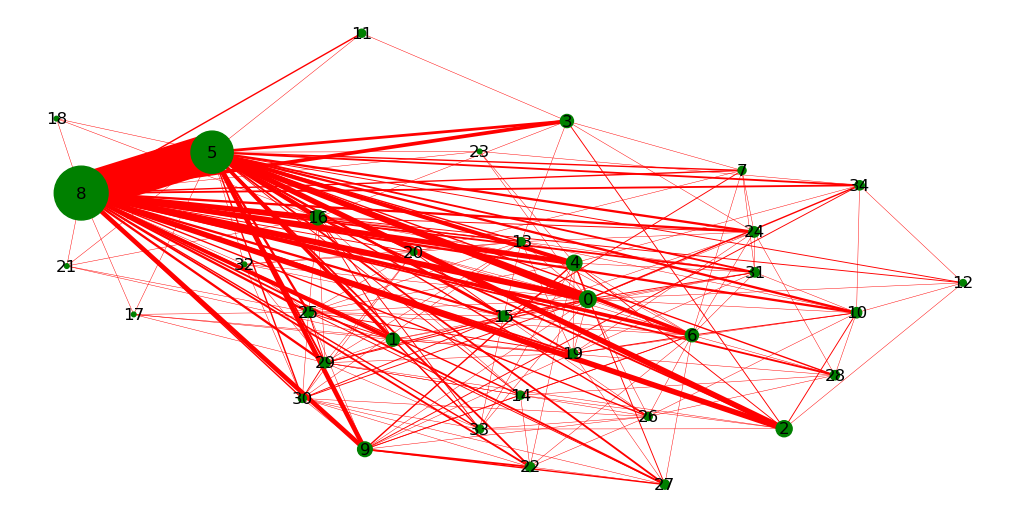

6
{0: 0.03333333333333333, 1: 0.05555555555555555, 2: 0.06666666666666667, 3: 0.2111111111111111, 4: 0.05555555555555555, 5: 0.9888888888888889, 6: 0.0, 7: 0.011111111111111112, 8: 0.03333333333333333, 9: 0.022222222222222223, 10: 0.07777777777777778, 11: 0.011111111111111112, 12: 0.044444444444444446, 13: 0.03333333333333333, 14: 0.0, 15: 0.011111111111111112, 16: 0.07777777777777778, 17: 0.03333333333333333, 18: 0.03333333333333333, 19: 0.011111111111111112, 20: 0.05555555555555555, 21: 0.05555555555555555, 22: 0.011111111111111112, 23: 0.011111111111111112, 24: 0.03333333333333333, 25: 0.0, 26: 0.0, 27: 0.03333333333333333, 28: 0.03333333333333333, 29: 0.03333333333333333, 30: 0.011111111111111112, 31: 0.0, 32: 0.011111111111111112, 33: 0.05555555555555555, 34: 0.0}
90


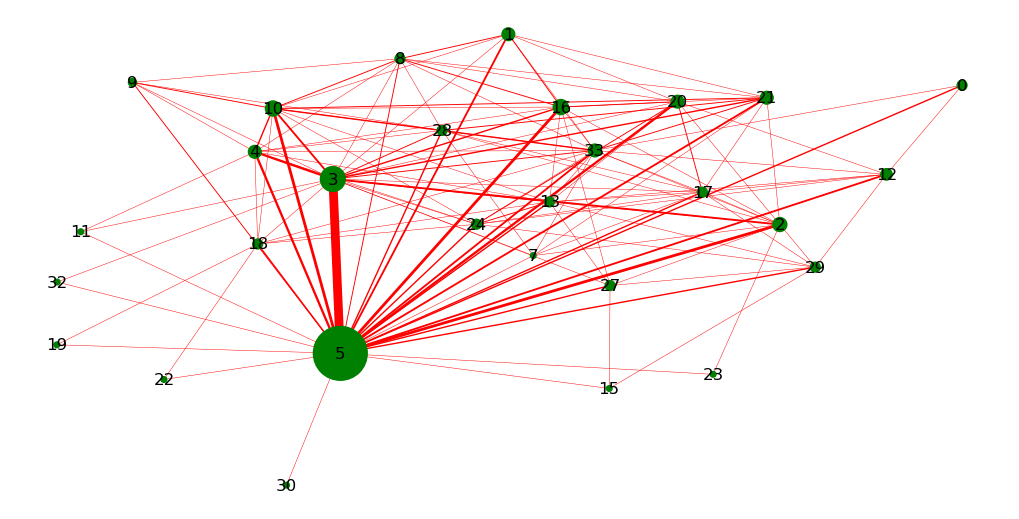

7
{0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0, 6: 0.050505050505050504, 7: 0.030303030303030304, 8: 0.0, 9: 0.0, 10: 0.06060606060606061, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.010101010101010102, 15: 0.0, 16: 0.0, 17: 0.020202020202020204, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.04040404040404041, 23: 0.030303030303030304, 24: 0.0, 25: 0.0, 26: 0.010101010101010102, 27: 0.010101010101010102, 28: 0.0, 29: 0.0, 30: 0.010101010101010102, 31: 0.010101010101010102, 32: 0.0, 33: 0.030303030303030304, 34: 0.0}
99


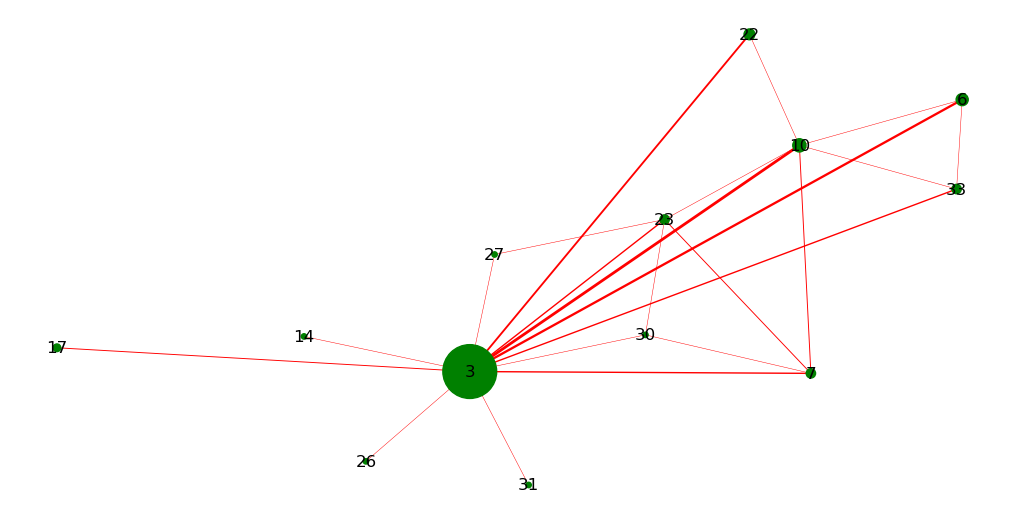

8
{0: 0.024390243902439025, 1: 0.0, 2: 0.008130081300813009, 3: 0.016260162601626018, 4: 0.032520325203252036, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.04065040650406504, 10: 0.016260162601626018, 11: 0.0, 12: 0.008130081300813009, 13: 0.0, 14: 0.008130081300813009, 15: 0.016260162601626018, 16: 0.0, 17: 0.04065040650406504, 18: 0.008130081300813009, 19: 0.016260162601626018, 20: 0.8780487804878049, 21: 0.016260162601626018, 22: 0.016260162601626018, 23: 0.016260162601626018, 24: 0.0, 25: 0.04878048780487805, 26: 0.016260162601626018, 27: 0.008130081300813009, 28: 0.0, 29: 0.0, 30: 0.008130081300813009, 31: 0.024390243902439025, 32: 0.3170731707317073, 33: 0.024390243902439025, 34: 0.056910569105691054}
123


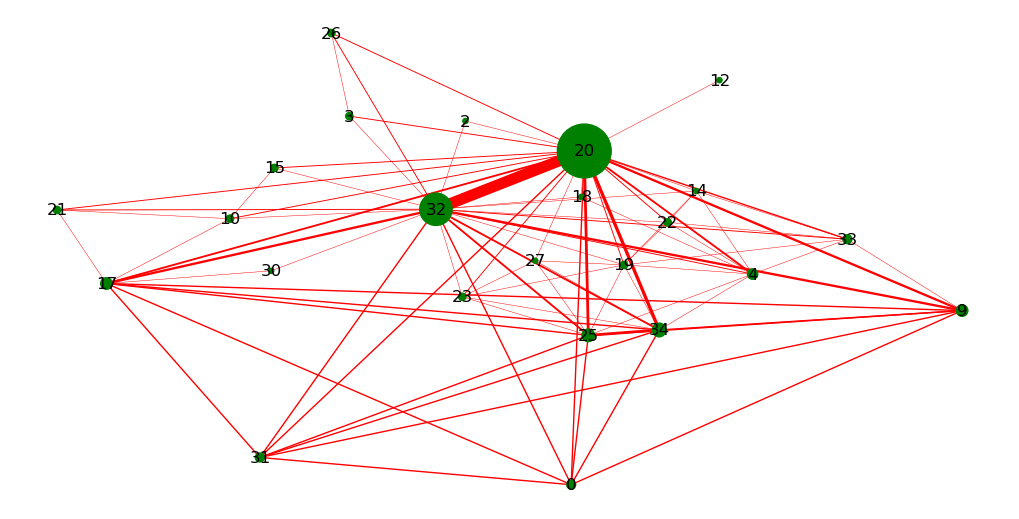

9
{0: 0.6196721311475409, 1: 0.1901639344262295, 2: 0.9639344262295082, 3: 0.26885245901639343, 4: 0.1377049180327869, 5: 0.04918032786885246, 6: 0.03934426229508197, 7: 0.04590163934426229, 8: 0.10819672131147541, 9: 0.07868852459016394, 10: 0.06885245901639345, 11: 0.05245901639344262, 12: 0.02622950819672131, 13: 0.07868852459016394, 14: 0.022950819672131147, 15: 0.03278688524590164, 16: 0.06557377049180328, 17: 0.06557377049180328, 18: 0.01639344262295082, 19: 0.03278688524590164, 20: 0.08196721311475409, 21: 0.06557377049180328, 22: 0.05245901639344262, 23: 0.03278688524590164, 24: 0.006557377049180328, 25: 0.04262295081967213, 26: 0.02622950819672131, 27: 0.06885245901639345, 28: 0.05573770491803279, 29: 0.07540983606557378, 30: 0.036065573770491806, 31: 0.02622950819672131, 32: 0.022950819672131147, 33: 0.019672131147540985, 34: 0.14098360655737704}
305


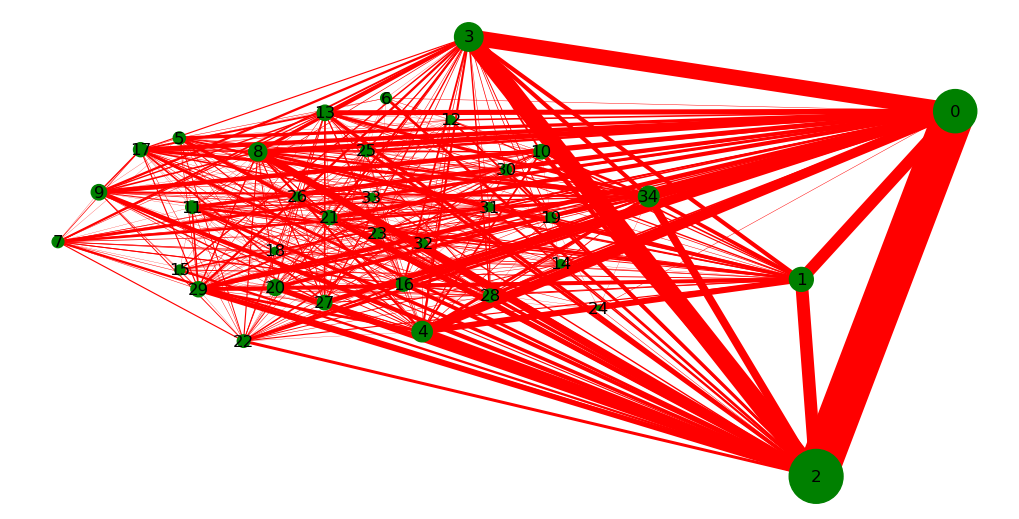

10
{0: 0.9241912119748914, 1: 0.5639787542250121, 2: 0.5951231289232255, 3: 0.5659101883148238, 4: 0.40391115403186867, 5: 0.4352969579913085, 6: 0.31675519072911634, 7: 0.4092225977788508, 8: 0.37083534524384354, 9: 0.2889908256880734, 10: 0.3877353935296958, 11: 0.28247223563495893, 12: 0.2556735876388218, 13: 0.29237083534524383, 14: 0.2737807822308064, 15: 0.2073877353935297, 16: 0.16755190729116368, 17: 0.23394495412844038, 18: 0.21511347175277643, 19: 0.21559633027522937, 20: 0.14751327860936744, 21: 0.18614196040560116, 22: 0.14365041042974408, 23: 0.16658619024625784, 24: 0.17334620956059874, 25: 0.16151617576050217, 26: 0.12650893288266538, 27: 0.14220183486238533, 28: 0.1460647030420087, 29: 0.10550458715596331, 30: 0.1030902945436987, 31: 0.104297440849831, 32: 0.0772573635924674, 33: 0.07918879768227909, 34: 0.021245774987928536}
4142


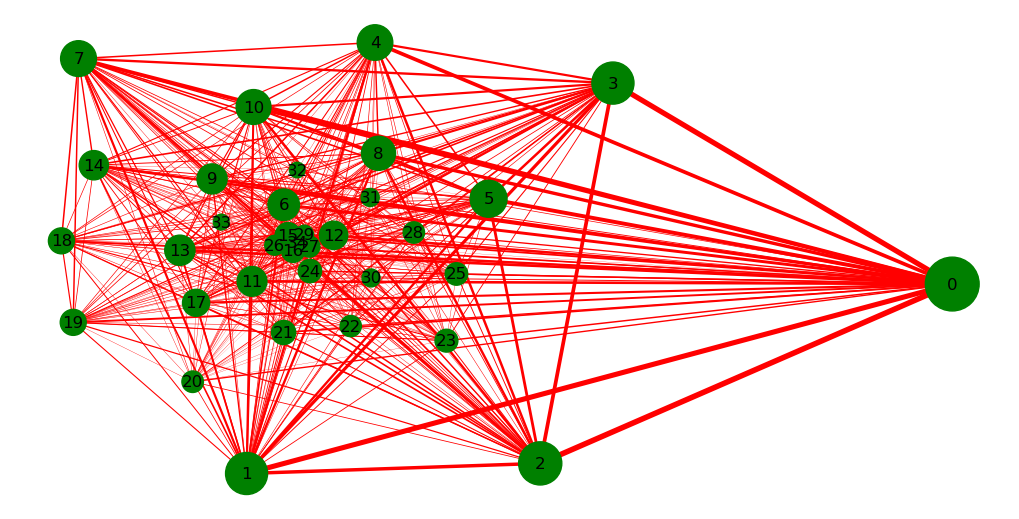

11
{0: 0.002881844380403458, 1: 0.9913544668587896, 2: 0.06051873198847262, 3: 0.06051873198847262, 4: 0.2017291066282421, 5: 0.0345821325648415, 6: 0.14697406340057637, 7: 0.037463976945244955, 8: 0.12680115273775217, 9: 0.020172910662824207, 10: 0.043227665706051875, 11: 0.12968299711815562, 12: 0.01729106628242075, 13: 0.037463976945244955, 14: 0.05187319884726225, 15: 0.040345821325648415, 16: 0.10086455331412104, 17: 0.04610951008645533, 18: 0.005763688760806916, 19: 0.03170028818443804, 20: 0.05475504322766571, 21: 0.07492795389048991, 22: 0.020172910662824207, 23: 0.011527377521613832, 24: 0.069164265129683, 25: 0.04899135446685879, 26: 0.10662824207492795, 27: 0.09798270893371758, 28: 0.069164265129683, 29: 0.11527377521613832, 30: 0.043227665706051875, 31: 0.025936599423631124, 32: 0.02881844380403458, 33: 0.06340057636887608, 34: 0.05475504322766571}
347


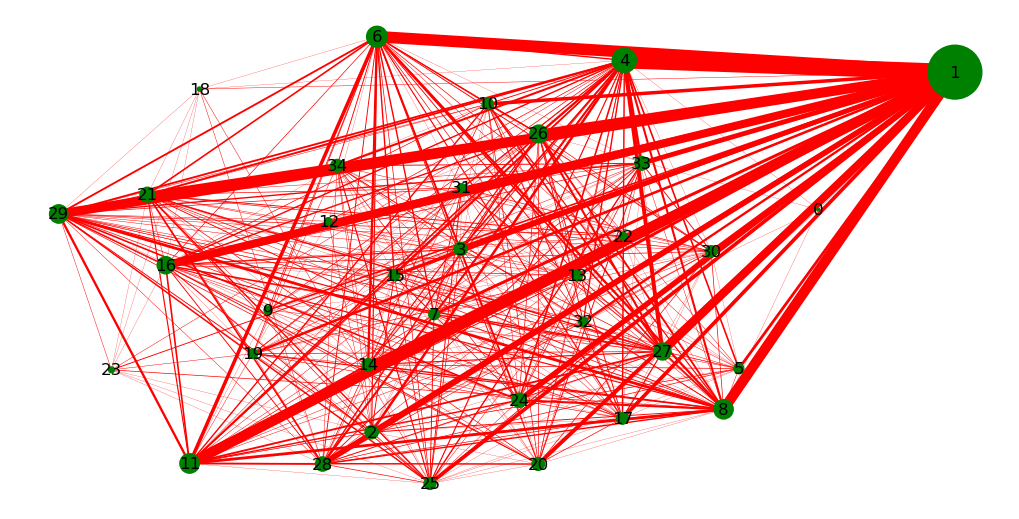

12
{0: 0.0, 1: 0.0, 2: 0.01098901098901099, 3: 0.0, 4: 0.027472527472527472, 5: 0.038461538461538464, 6: 1.0, 7: 0.01098901098901099, 8: 0.03296703296703297, 9: 0.0, 10: 0.005494505494505495, 11: 0.016483516483516484, 12: 0.038461538461538464, 13: 0.03296703296703297, 14: 0.005494505494505495, 15: 0.02197802197802198, 16: 0.11538461538461539, 17: 0.016483516483516484, 18: 0.0, 19: 0.01098901098901099, 20: 0.04945054945054945, 21: 0.01098901098901099, 22: 0.02197802197802198, 23: 0.027472527472527472, 24: 0.016483516483516484, 25: 0.01098901098901099, 26: 0.0, 27: 0.0, 28: 0.027472527472527472, 29: 0.01098901098901099, 30: 0.0, 31: 0.016483516483516484, 32: 0.027472527472527472, 33: 0.016483516483516484, 34: 0.016483516483516484}
182


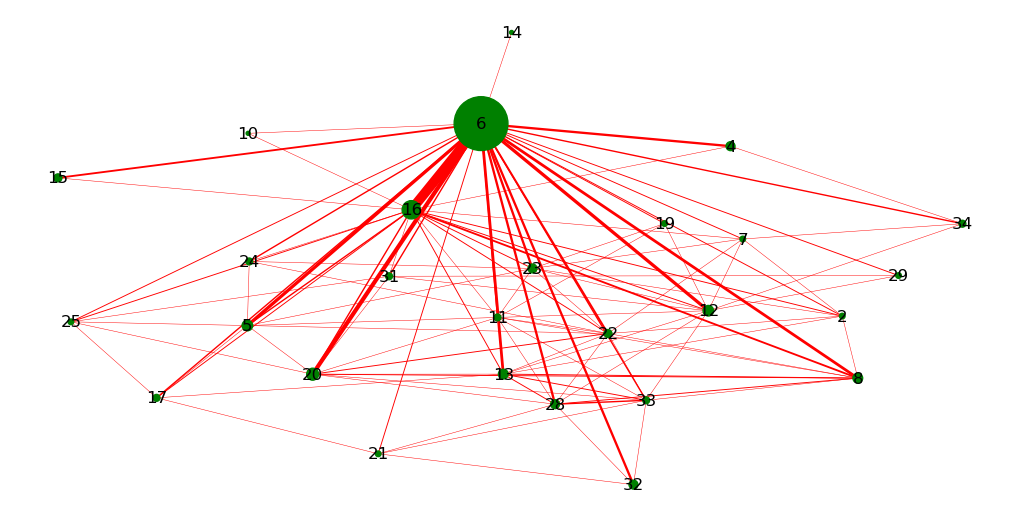

13
{0: 0.0, 1: 0.0, 2: 0.009615384615384616, 3: 0.0, 4: 0.019230769230769232, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.009615384615384616, 10: 0.019230769230769232, 11: 0.028846153846153848, 12: 0.0, 13: 0.009615384615384616, 14: 0.0, 15: 0.019230769230769232, 16: 1.0, 17: 0.009615384615384616, 18: 0.009615384615384616, 19: 0.0, 20: 0.04807692307692308, 21: 0.019230769230769232, 22: 0.038461538461538464, 23: 0.0, 24: 0.019230769230769232, 25: 0.009615384615384616, 26: 0.019230769230769232, 27: 0.0, 28: 0.009615384615384616, 29: 0.019230769230769232, 30: 0.009615384615384616, 31: 0.0, 32: 0.038461538461538464, 33: 0.009615384615384616, 34: 0.028846153846153848}
104


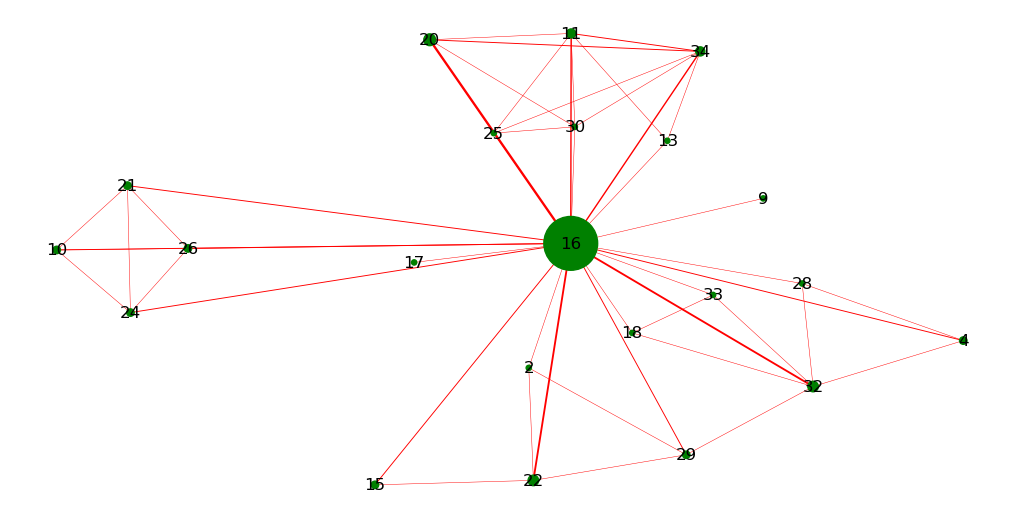

14
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.05263157894736842, 4: 0.9894736842105263, 5: 0.0, 6: 0.0, 7: 0.021052631578947368, 8: 0.0, 9: 0.010526315789473684, 10: 0.010526315789473684, 11: 0.021052631578947368, 12: 0.010526315789473684, 13: 0.0, 14: 0.010526315789473684, 15: 0.0, 16: 0.021052631578947368, 17: 0.010526315789473684, 18: 0.0, 19: 0.0, 20: 0.010526315789473684, 21: 0.031578947368421054, 22: 0.10526315789473684, 23: 0.021052631578947368, 24: 0.021052631578947368, 25: 0.010526315789473684, 26: 0.05263157894736842, 27: 0.010526315789473684, 28: 0.042105263157894736, 29: 0.021052631578947368, 30: 0.021052631578947368, 31: 0.021052631578947368, 32: 0.010526315789473684, 33: 0.010526315789473684, 34: 0.010526315789473684}
95


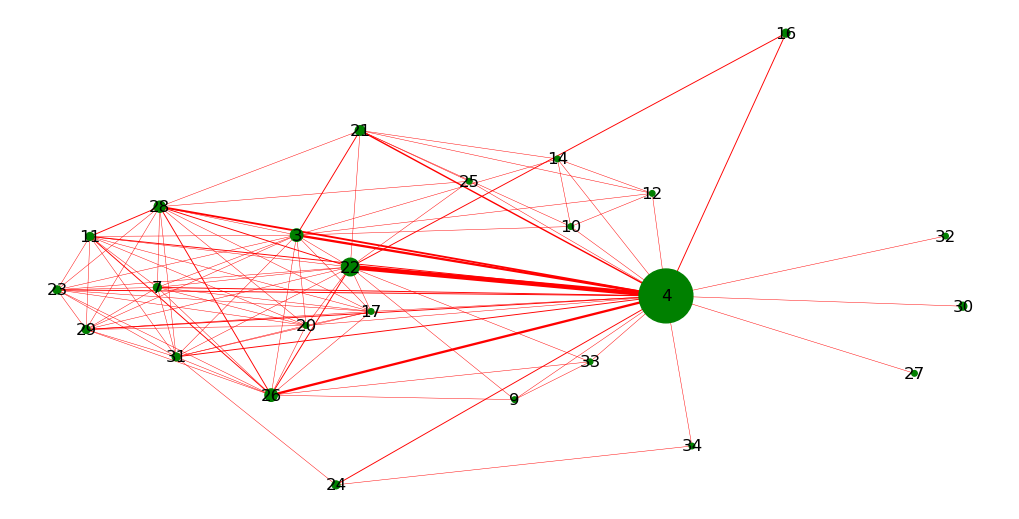

15
{0: 0.0, 1: 0.0, 2: 0.010869565217391304, 3: 0.0, 4: 0.010869565217391304, 5: 0.010869565217391304, 6: 0.06521739130434782, 7: 0.03260869565217391, 8: 0.0, 9: 0.010869565217391304, 10: 0.03260869565217391, 11: 0.010869565217391304, 12: 0.0, 13: 0.010869565217391304, 14: 0.10869565217391304, 15: 0.010869565217391304, 16: 0.010869565217391304, 17: 0.010869565217391304, 18: 0.0, 19: 0.0, 20: 0.010869565217391304, 21: 0.010869565217391304, 22: 0.043478260869565216, 23: 0.0, 24: 0.0, 25: 0.010869565217391304, 26: 0.967391304347826, 27: 0.010869565217391304, 28: 0.03260869565217391, 29: 0.0, 30: 0.021739130434782608, 31: 0.010869565217391304, 32: 0.021739130434782608, 33: 0.010869565217391304, 34: 0.021739130434782608}
92


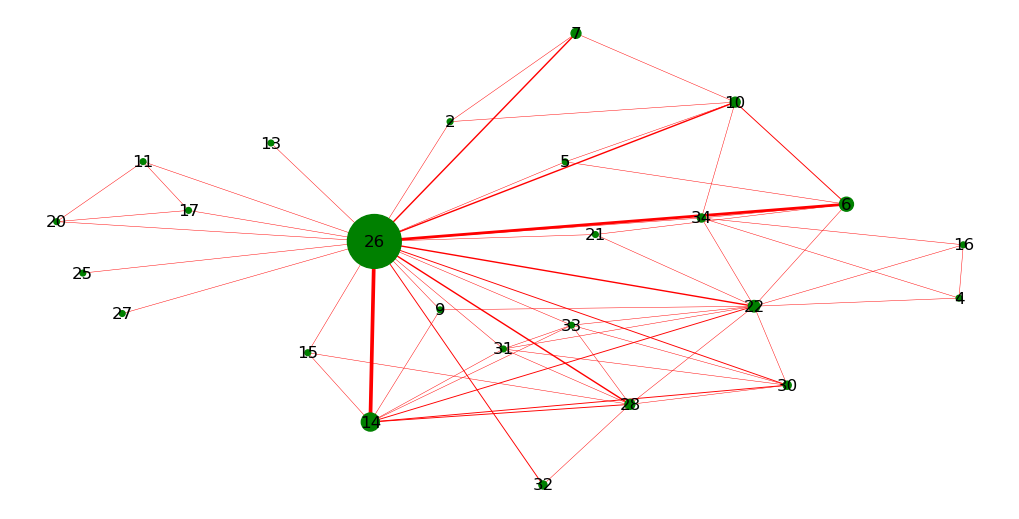

In [34]:
clusters = [old_data[k.labels_ == i] for i in range(n_clusters)]
for see_cluster in range(n_clusters):
    print(see_cluster)
#     print(np.where(np.mean(clusters[see_cluster],0) > 0.75)[0])
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
#     print([x for x in edge_list if x[2]['weight'] > 0.25*len(clusters[see_cluster])])

    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_kamada_kawai(G, node_size=node_size, with_labels=True, edgelist=edges, width=weights, **options)
    plt.show()


In [39]:
sum(Profile(approval_profile_files[i][0]).ballots)

array([5079., 3502., 3118., 3028., 2504., 2384., 2276., 2105., 2057.,
       2052., 2025., 1705., 1701., 1624., 1430., 1405., 1323., 1289.,
       1256., 1223., 1114., 1098., 1001.,  996.,  974.,  969.,  953.,
        949.,  878.,  758.,  679.,  632.,  574.,  571.,  565.])